In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, AutoModel,AutoConfig,get_constant_schedule_with_warmup, BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score,f1_score,average_precision_score
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler

import torch
from torch import nn
import time
import random
import datetime
import math

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


tqdm.pandas()

In [2]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [3]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0,is_loss=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.is_loss = is_loss
        if is_loss:
            self.min_validation_loss = np.inf
        else:
            self.min_validation_loss = -np.inf

    def early_stop(self, validation_loss,save_best=False,model=None):
        if self.is_loss:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW LOWEST LOSS ",self.min_validation_loss)
                if save_best:
                    torch.save(model.state_dict(), "../models/temp")
                    
            elif validation_loss >= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        else:
            if validation_loss > self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW HIGHEST SCORE ",self.min_validation_loss)
                if save_best:
                    torch.save(model.state_dict(), "../models/temp")

            elif validation_loss <= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

In [4]:
stop = EarlyStopper(is_loss=False)

In [5]:
class Multitask(nn.Module):
    def __init__(self,num_primary_labels, num_auxiliary_labels,transformer,input_size=512):
        super(Multitask,self).__init__()
        self.transformer = transformer
        self.primary_head = nn.Linear(input_size,num_primary_labels)
        self.auxiliary_head = nn.Linear(input_size,num_auxiliary_labels)
        
        self.sigmoid = torch.sigmoid
        
    def forward(self,input_ids,input_mask):
        input_arr = transformer(input_ids,attention_mask=input_mask)[-1]
        primary_logits = self.primary_head(input_arr)
        auxiliary_logits = self.auxiliary_head(input_arr)
        
        
        return primary_logits,auxiliary_logits


In [6]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
max_length = 128


remove_neutral_instances = False


learning_rate =  5e-5
epsilon = 1e-8
num_train_epochs = 40
multi_gpu = True

apply_scheduler = False
warmup_proportion = 0.1

T = 3

filter_emotions = False

print_each_n_step = 100

batch_size = 16
kl_weight = T*T

model_path = "neuralmind/bert-base-portuguese-cased"

alpha = 0.5
eps = 1e-8


In [8]:
df = pd.read_csv("../features/both tasks facebook + reddit + goemotions.csv",index_col = 0)

train_df,test_df, _, _ = train_test_split(df,df,test_size=0.2,shuffle=True,random_state=seed_val)

In [9]:
emotion_dict = {
    "admiração": 0,
    "diversão": 1,
    "raiva": 2,
    "aborrecimento": 3,
    "aprovação": 4,
    "zelo": 5,
    "confusão": 6,
    "curiosidade": 7,
    "desejo": 8,
    "decepção": 9,
    "desaprovação": 10,
    "nojo": 11,
    "constrangimento": 12,
    "entusiasmo": 13,
    "medo": 14,
    "gratidão": 15,
    "luto": 16,
    "alegria": 17,
    "amor": 18,
    "nervosismo": 19,
    "otimismo": 20,
    "orgulho": 21,
    "percepção": 22,
    "alívio": 23,
    "remorso": 24,
    "tristeza": 25,
    "surpresa": 26,
    "neutro": 27
}

In [10]:
df1 = pd.read_csv("../data/segredos_sentenças_multitask_clean.csv",index_col=0)

df1 = df1.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

#df1 = df1.reset_index(drop=True)
#df1 = df1[df1.iloc[:,1:].sum(axis=1) != 0]

df1 = df1.reset_index(drop=True)
symptom_num = df1.iloc[:,1:].shape[1]
emotion_num = len(emotion_dict)

In [11]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
symptoms = df1.iloc[:,1:]
strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df1,symptoms)

In [12]:
for train_idx, test_idx in strat:

    symptoms_train = symptoms.loc[train_idx]
    symptoms_test  = symptoms.loc[test_idx]
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]
    break

In [13]:
remaining = df.loc[~df.index.isin(train_idx)]
remaining = remaining.loc[~remaining.index.isin(test_idx)]

train_remaining,test_remaining, _, _ = train_test_split(remaining,remaining,test_size=0.2,shuffle=True,random_state=seed_val)

In [14]:
train_df = pd.concat([train_df,train_remaining]).reset_index(drop=True)
test_df = pd.concat([test_df,test_remaining]).reset_index(drop=True)

In [15]:
def fill_unlabeled(symptoms,df):
    data = []
    for row in range(df.shape[0] - symptoms.shape[0]):
        data.append([-1] * symptom_num)
    data = pd.DataFrame(data)
    data.columns = symptoms.columns
    symptoms = pd.concat([symptoms,data],axis=0)
    return symptoms.reset_index(drop=True)



In [16]:
to_keep = ["neutro", "raiva", "zelo","confusão", "desejo","decepção","desaprovação","gratidão","luto","amor", "tristeza"]
#to_keep = ['medo', 'tristeza','raiva','zelo']

if filter_emotions:
    drop=  []
    for key in emotion_dict:
        if key in to_keep:
            drop.append(key)

    for key in drop:
        del emotion_dict[key]
    if filter_emotions:
        idx = [str(emotion_dict[key])+".1" if emotion_dict[key] < symptom_num else str(emotion_dict[key]) for key in emotion_dict ]
        train_df = train_df.drop(idx,axis=1)
    emotion_num = len(drop)   


In [17]:
#symptoms_train = fill_unlabeled(symptoms_train,train_df)
#symptoms_test = fill_unlabeled(symptoms_test,test_df)

In [18]:
transformer = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
config = AutoConfig.from_pretrained(model_path)
hidden_size = int(config.hidden_size)
model = Multitask(symptom_num,emotion_num,transformer,input_size = hidden_size)

In [20]:
transformer = transformer.to(device)
model = model.to(device)

In [21]:
#dataloaders

max_length = 128

def get_dataloader(df,tokenizer,labels,batch_size,do_shuffle):
    examples = []
    input_ids = []
    attention_masks = []
    for text in df.text:
        encoded = tokenizer.encode_plus(text,return_attention_mask=True,add_special_tokens=True,max_length = max_length,
    padding="max_length",truncation=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    df = df.drop("text",axis=1)

    logits = torch.tensor(df.iloc[:,:symptom_num + emotion_num].to_numpy(),dtype=torch.float32)
    
    labels = torch.tensor(np.concatenate((labels.to_numpy(),torch.nn.functional.sigmoid(logits[labels.shape[0]:,:symptom_num]))),dtype=torch.float32)
    labeled = torch.tensor(np.concatenate((np.ones(labels.size()[0]), np.zeros(logits.size()[0] - labels.size()[0]))))
    # modificando logits
    #with torch.no_grad():
    #    logits[:labels.size()[0],:symptom_num] = (logits[:labels.size()[0],:symptom_num] + labels)/2
    
    
    dataset = torch.utils.data.TensorDataset(input_ids,attention_masks,logits,labeled,labels)
    
    if do_shuffle:
        sampler = torch.utils.data.RandomSampler
    else:
        sampler = torch.utils.data.SequentialSampler
    return torch.utils.data.DataLoader(dataset,sampler = sampler(dataset),batch_size=batch_size)
    
       

In [22]:
train_dataloader = get_dataloader(train_df,tokenizer,symptoms_train,batch_size,do_shuffle=True)
#test_dataloader = get_dataloader(test_df,tokenizer,symptoms_test,batch_size,do_shuffle=False)

# Teste

In [23]:
df = pd.read_csv("../data/segredos_sentenças_multitask_clean.csv",index_col=0)
df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)
symptom_num = df.iloc[:,1:].shape[1]
target_names = list(df.iloc[:,1:].columns)

if remove_neutral_instances == True:
    df = df.reset_index(drop=True)
    df = df[df.iloc[:,1:].sum(axis=1) != 0]

df = df.reset_index(drop=True)

In [24]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df1,symptoms)

for train_idx, test_idx in strat:

    train_df = df1.loc[train_idx]
    test_df  = df1.loc[test_idx]
    break

In [25]:
test_labels = test_df.iloc[:,1:]
test_text = test_df.text

In [26]:
inputs = []
attention_masks =[]

for text in test_text:
    encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    inputs.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])

labels = torch.tensor(test_labels.to_numpy(),dtype=torch.float32)    
inputs = torch.stack(inputs)
attention_masks = torch.stack(attention_masks)

dataset = TensorDataset(inputs, attention_masks,labels)
symptom_dataloader = DataLoader(
              dataset,
              sampler = SequentialSampler(dataset), 
              batch_size = batch_size)

# Treino

In [27]:
def naive_combination(p_loss,a_loss,alpha=0.5):
    return p_loss * alpha + a_loss * (1-alpha)

In [28]:
def variance_loss(losses,var_logs):
    total_loss = 0
    for i,loss in enumerate(losses):
        total_loss += loss * torch.exp(-var_logs[i]) + var_logs[i]
    #total_loss += torch.prod(torch.tensor(var_logs))
    return total_loss

In [29]:
def distillation_loss(student,teacher,weights,b_labels,labeled_weight = 10):
    loss = torch.nn.MSELoss(reduction='none')
    student = torch.nn.functional.sigmoid(student)
    teacher = torch.nn.functional.sigmoid(teacher)
    
    if b_labels != None:
        teacher = (teacher + b_labels)/2 

    l = loss(student,teacher)
    
    
    l = l + (l.T * (weights * labeled_weight)).T
    return l.mean()/student.size(0)

In [30]:
def kl_loss(student,teacher):
    pass

In [31]:
def focal_loss(p,targets,gamma=3,alpha=0.8):
    bce = torch.nn.BCELoss()(p,targets)
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1-alpha)

    return (alpha * (1-p) ** gamma).mean()

In [32]:
model = model.to(device)

In [33]:
training_stats=[]
#torch.autograd.set_detect_anomaly(True)
log_var_a = torch.zeros((1,),requires_grad=True,device=device)
log_var_b = torch.zeros((1,),requires_grad=True,device=device)
#learning rate diferentes para cada um desses


model_vars = [i for i in model.parameters()]
variance_vars = [log_var_a] + [log_var_b]
#model_vars = combined_model.get_prim_params() + combined_model.get_aux_params()

optimizer = torch.optim.AdamW([{"params":model_vars},{"params":variance_vars,"lr":0.0001}],lr=learning_rate)

sigmoid = nn.functional.sigmoid
#prim_optimizer = torch.optim.AdamW([{"params":combined_model.get_prim_params()},{"params":alpha_vars,"lr":0.01}])
#aux_optimizer = torch.optim.AdamW([{"params":combined_model.get_aux_params()},{"params":alpha_vars,"lr":0.01}])


if apply_scheduler:
    num_train_steps = int(len(train_dataloader) * num_train_epochs)
    
    num_warmup_steps = int(num_train_steps * warmup_proportion)
    scheduler = get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    
    
    #num_warmup_steps = int(num_train_steps * warmup_proportion * 2)

    #prim_scheduler = get_constant_schedule_with_warmup(prim_optimizer, 
    #                                       num_warmup_steps = num_warmup_steps)
    #aux_scheduler = get_constant_schedule_with_warmup(aux_optimizer, 
    #                                       num_warmup_steps = num_warmup_steps)





#primary_loss_func = lambda x,y: focal_loss(x,y,gamma=3,alpha=get_inverse_class_freqs(primary_train.iloc[:,1:]))
#auxiliary_loss_func = lambda x,y:focal_loss(x,y,gamma=3,alpha=get_inverse_class_freqs(emotion_labels_train))
primary_loss_func = distillation_loss
auxiliary_loss_func = distillation_loss
multitask_loss_func = naive_combination

best_f1_primary = 0
best_f1_auxiliary = 0
best_epoch_primary = 0
best_epoch_auxiliary = 0
best_average_precision_primary = 0
best_average_precision_auxiliary = 0
best_report_primary = {}
best_report_auxiliary = {}




for epoch_i in range(num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()

    tr_loss = 0
    pr_loss = 0
    aux_loss = 0
    primary_num = 0
    auxiliary_num = 0
    
    model.train()
    
    for step,batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step ==0:
            
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
        b_input_ids = batch[0].to(device).reshape(len(batch[0]),max_length)
        b_attention_mask = batch[1].to(device).reshape(len(batch[1]),max_length)
        b_logits = batch[2].to(device)
        b_labeled = batch[3].to(device)
        b_labels = batch[4].to(device)
        
        b_primary_logits = b_logits[:,:symptom_num]
        b_auxiliary_logits = b_logits[:,symptom_num:]
        
        prim_outputs, aux_outputs = model(b_input_ids,b_attention_mask)
        
    
        
        temp_func_prim = lambda x,y : primary_loss_func(x,y,b_labeled,b_labels)
        temp_func_aux = lambda x,y : primary_loss_func(x,y,torch.zeros_like(b_labeled),None)


        losses = [temp_func_prim(prim_outputs,b_primary_logits),temp_func_aux(aux_outputs,b_auxiliary_logits)]
        #batch_loss = multitask_loss_func(losses,variance_vars)
        batch_loss = multitask_loss_func(losses[0],losses[1])

        pr_loss += losses[0].item()
        aux_loss += losses[1].item()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        if apply_scheduler:
            scheduler.step()
        
    
        tr_loss += batch_loss.item()
        
    
    avg_train_loss = tr_loss/len(train_dataloader)
    avg_pr_loss = pr_loss/len(train_dataloader)

    avg_aux_loss = aux_loss/len(train_dataloader)

    training_time = format_time(time.time()-t0)
        
    print("  Average training loss: {:}".format(avg_train_loss))
    print("  Average prim loss: {:}".format(avg_pr_loss))

    print("  Average aux loss: {:}".format(avg_aux_loss))

    print("  Training epoch took: {:}".format(training_time))
    
    t0 = time.time()
    
    primary_num = 0
    auxiliary_num = 0
    
    
    p_test_loss = 0
    a_test_loss = 0
    total_test_loss = 0
    
    all_probs = []
    all_labels_ids = []
    model.eval()
    
    for batch in symptom_dataloader:
        b_input_ids = batch[0].reshape(len(batch[0]),max_length).to(device)
        b_input_mask = batch[1].reshape(len(batch[0]),max_length).to(device)
        b_labels = batch[2].to(device)
        cur_batch_size = b_input_ids.shape[0]
        
        
        with torch.no_grad():

            output,_ = model(b_input_ids,b_input_mask)
            preds = torch.nn.functional.sigmoid(output)
            loss = focal_loss(preds,b_labels)
            for el in preds:
                all_probs.append(el.detach().cpu())
            for el in b_labels:
                all_labels_ids.append(el.detach().cpu())
            
            
            total_test_loss += loss.item()

    all_probs = torch.stack(all_probs).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    cur_auc = average_precision_score(all_labels_ids,all_probs)

    print("auc:",cur_auc)    
    avg_test_loss = total_test_loss/len(symptom_dataloader)
     
        
    print("test Loss:", avg_test_loss)


    if stop.early_stop(cur_auc,save_best=True,model=model):
        #pass
        break
        
    
    


======== Epoch 1 / 40 ========
Training...
  Batch   100  of  2,411.    Elapsed: 0:00:11.
  Batch   200  of  2,411.    Elapsed: 0:00:21.
  Batch   300  of  2,411.    Elapsed: 0:00:31.
  Batch   400  of  2,411.    Elapsed: 0:00:41.
  Batch   500  of  2,411.    Elapsed: 0:00:51.
  Batch   600  of  2,411.    Elapsed: 0:01:01.
  Batch   700  of  2,411.    Elapsed: 0:01:11.
  Batch   800  of  2,411.    Elapsed: 0:01:21.
  Batch   900  of  2,411.    Elapsed: 0:01:32.
  Batch 1,000  of  2,411.    Elapsed: 0:01:42.
  Batch 1,100  of  2,411.    Elapsed: 0:01:52.
  Batch 1,200  of  2,411.    Elapsed: 0:02:02.
  Batch 1,300  of  2,411.    Elapsed: 0:02:13.
  Batch 1,400  of  2,411.    Elapsed: 0:02:23.
  Batch 1,500  of  2,411.    Elapsed: 0:02:33.
  Batch 1,600  of  2,411.    Elapsed: 0:02:44.
  Batch 1,700  of  2,411.    Elapsed: 0:02:54.
  Batch 1,800  of  2,411.    Elapsed: 0:03:04.
  Batch 1,900  of  2,411.    Elapsed: 0:03:14.
  Batch 2,000  of  2,411.    Elapsed: 0:03:25.
  Batch 2,100  o

  Batch 2,400  of  2,411.    Elapsed: 0:04:06.
  Average training loss: 0.00019656036845144915
  Average prim loss: 0.00029843000482625965
  Average aux loss: 9.469073207663898e-05
  Training epoch took: 0:04:07
auc: 0.3422007750324705
test Loss: 0.006809677853173501

======== Epoch 7 / 40 ========
Training...
  Batch   100  of  2,411.    Elapsed: 0:00:10.
  Batch   200  of  2,411.    Elapsed: 0:00:20.
  Batch   300  of  2,411.    Elapsed: 0:00:31.
  Batch   400  of  2,411.    Elapsed: 0:00:41.
  Batch   500  of  2,411.    Elapsed: 0:00:51.
  Batch   600  of  2,411.    Elapsed: 0:01:01.
  Batch   700  of  2,411.    Elapsed: 0:01:12.
  Batch   800  of  2,411.    Elapsed: 0:01:22.
  Batch   900  of  2,411.    Elapsed: 0:01:32.
  Batch 1,000  of  2,411.    Elapsed: 0:01:42.
  Batch 1,100  of  2,411.    Elapsed: 0:01:53.
  Batch 1,200  of  2,411.    Elapsed: 0:02:03.
  Batch 1,300  of  2,411.    Elapsed: 0:02:13.
  Batch 1,400  of  2,411.    Elapsed: 0:02:23.
  Batch 1,500  of  2,411.    E

# teste

In [34]:
model.load_state_dict(torch.load("../models/temp"))

<All keys matched successfully>

In [35]:
df = pd.read_csv("../data/segredos_sentenças_multitask_clean.csv",index_col=0)
df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)
symptom_num = df.iloc[:,1:].shape[1]
target_names = list(df.iloc[:,1:].columns)

if remove_neutral_instances == True:
    df = df.reset_index(drop=True)
    df = df[df.iloc[:,1:].sum(axis=1) != 0]

df = df.reset_index(drop=True)

In [36]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df,df.iloc[:,1:])
#strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df1,symptoms)

for train_idx, test_idx in strat:

    train_df = df.loc[train_idx]
    test_df  = df.loc[test_idx]
    break

In [37]:
test_labels = test_df.iloc[:,1:]
test_text = test_df.text

In [38]:
inputs = []
attention_masks =[]

for text in test_text:
    encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    inputs.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])
        
inputs = torch.stack(inputs)
attention_masks = torch.stack(attention_masks)

dataset = TensorDataset(inputs, attention_masks)
symptom_dataloader = DataLoader(
              dataset,
              sampler = SequentialSampler(dataset), 
              batch_size = batch_size)

In [39]:
probs = []
for step,batch in enumerate(symptom_dataloader):
    model.eval()
    b_input_ids = batch[0].reshape(len(batch[0]),max_length).to(device)
    b_attention_mask = batch[1].reshape(len(batch[0]),max_length).to(device)

     
    with torch.no_grad():
        outputs,_ = model(b_input_ids,b_attention_mask)
        for b_prob in (torch.nn.functional.sigmoid(outputs).detach().cpu()):
            probs.append(b_prob)
probs = torch.stack(probs).numpy()

In [40]:
probs.shape

(2361, 18)

In [41]:
test_labels.shape

(2361, 18)

In [42]:
from sklearn.metrics import precision_recall_curve,average_precision_score
preds = []
for i in range (probs.shape[1]):
    precision,recall,thresholds = precision_recall_curve(test_labels.iloc[:,i],probs[:,i])
    f1_scores = 2*recall*precision/(recall+precision)
    cur_threshold = thresholds[np.nanargmax(f1_scores)]
    print("melhor f1 para ",df.columns[i+1]," ",np.nanmax(f1_scores))
    preds.append(probs[:,i] >= cur_threshold)
    
best_preds = np.array(preds).T
best_fine_tuning_report = classification_report(test_labels,best_preds,target_names=target_names, zero_division=0,output_dict=True)


melhor f1 para  Alteração de sono   0.6666666666666667
melhor f1 para  Alteração na eficiência/funcionalidade   0.4307692307692308
melhor f1 para  Tristeza/Humor depressivo   0.50920245398773
melhor f1 para  Desamparo/Prejuízo social/Solidão   0.48299319727891155
melhor f1 para  Suicído/Auto-extermínio   0.6606334841628959
melhor f1 para  Preocupação/Medo /Ansiedade   0.6086956521739131
melhor f1 para  Desesperança   0.3829787234042554
melhor f1 para  Desvalia / Baixa autoestima   0.5507246376811593
melhor f1 para  Fator de risco   0.37606837606837606
melhor f1 para  Irritação / agressividade   0.2
melhor f1 para  Sintoma físico   0.3636363636363637
melhor f1 para  Sentimento de culpa   0.25
melhor f1 para  Morte / Suicído de outro   0.5
melhor f1 para  Fator protetivo, cuidado em saúde e bem-estar   0.4029850746268656
melhor f1 para  Dificuldade para decidir   0.125
melhor f1 para  Cansaço/Desânimo/Desencorajamento/Fadiga/Perda de energia / Lentificação   0.43373493975903615
melhor f1

/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3010839384.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


In [43]:
print("average precision score: ",average_precision_score(test_labels,probs,average=None))

average precision score:  [0.52858151 0.30684707 0.45170458 0.4806441  0.66827889 0.55387705
 0.29368987 0.49788583 0.31628888 0.14829271 0.15801324 0.22550706
 0.37372169 0.35347969 0.03786851 0.39689249 0.24071417 0.63148862]


<AxesSubplot:>

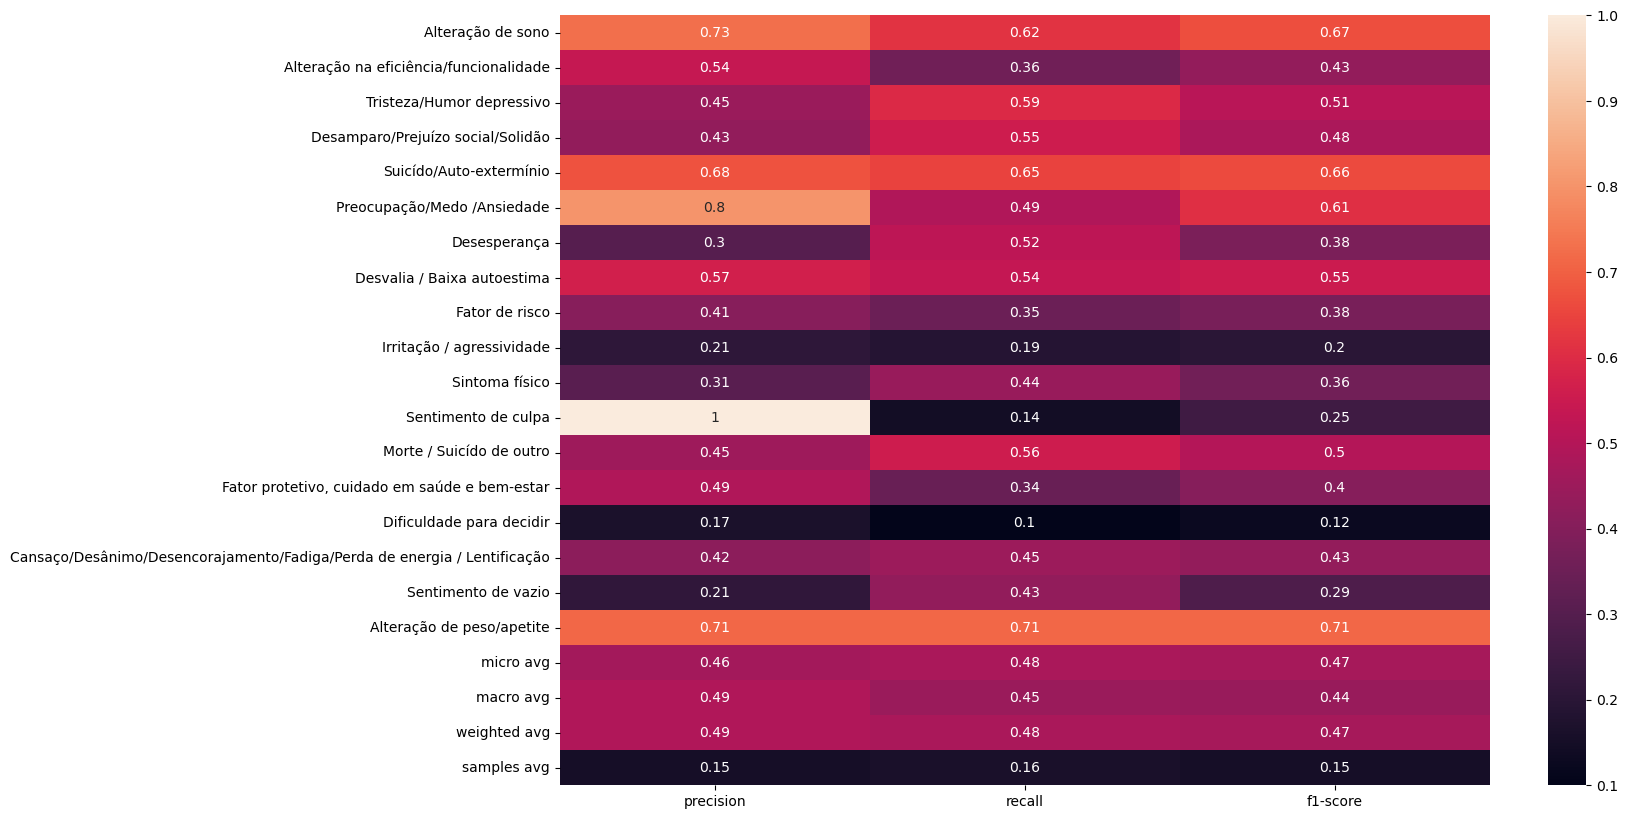

In [44]:

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

In [45]:
#LEMBRETE: se for usar o córpus associado com o GoEmotions, tem que fazer a divisão certinha lá em cima, senão vaza dados

go_emotions_path = "../data/goemotions"

test = pd.read_csv(f"{go_emotions_path}/test.tsv",sep='\t')

emotion_dict = {

    "admiração": 0,

    "diversão": 1,

    "raiva": 2,

    "aborrecimento": 3,

    "aprovação": 4,

    "zelo": 5,

    "confusão": 6,

    "curiosidade": 7,

    "desejo": 8,

    "decepção": 9,

    "desaprovação": 10,

    "nojo": 11,

    "constrangimento": 12,

    "entusiasmo": 13,

    "medo": 14,

    "gratidão": 15,

    "luto": 16,

    "alegria": 17,

    "amor": 18,

    "nervosismo": 19,

    "otimismo": 20,

    "orgulho": 21,

    "percepção": 22,

    "alívio": 23,

    "remorso": 24,

    "tristeza": 25,

    "surpresa": 26,

    "neutro": 27

}
if filter_emotions:
    idx = [emotion_dict[key] for key in to_keep]

    def filter_dropped(row,idx):

        for label in row.labels.split(","):

            if int(label) not in list(idx):

                return {}

        return row

    #test = test.apply(lambda x: filter_dropped(x,idx),axis=1).dropna()

    to_drop =[]
    for key in emotion_dict:
        if key not in to_keep:
            to_drop.append(key)
    for key in to_drop:
        del emotion_dict[key]

def change_label_encoding(row):

    labels = row['labels'].replace(" ","").split(",")

    new_row = {}

    for emotion in emotion_dict:

        if str(emotion_dict[emotion]) in labels:

            new_row[emotion] = True

        else:

            new_row[emotion] = False

    return new_row

test_labels = pd.DataFrame(list(test.apply(change_label_encoding,axis=1)))

test_inputs = list(test.text.apply(lambda x: x[:512] if len(x) > 512 else x))


inputs = []

attention_masks =[]

for text in test_inputs:

    encoding = tokenizer.encode_plus(

            text,

            add_special_tokens=True,

            max_length=128,

            return_token_type_ids=False,

            padding="max_length",

            truncation=True,

            return_attention_mask=True,

            return_tensors='pt',

        )

    inputs.append(encoding['input_ids'])

    attention_masks.append(encoding['attention_mask'])

        

inputs = torch.stack(inputs)

attention_masks = torch.stack(attention_masks)


dataset = TensorDataset(inputs, attention_masks)

emotion_dataloader = DataLoader(

              dataset,

              sampler = SequentialSampler(dataset), 

              batch_size = batch_size)


softmax = torch.nn.Softmax()

predictions = []

threshold = 0.7

model.eval()
for step,batch in enumerate(emotion_dataloader):

        b_input_ids = batch[0].reshape(len(batch[0]),max_length).to(device)

        b_attention_mask = batch[1].reshape(len(batch[0]),max_length).to(device)

       

        

        with torch.no_grad():

            _,auxiliary_logits = model(b_input_ids,b_attention_mask)

            for b_pred in (torch.nn.functional.sigmoid(auxiliary_logits).detach().cpu()):

                predictions.append(b_pred)

probs = torch.stack(predictions) 



In [46]:
probs.shape

torch.Size([5427, 28])

In [47]:
test_labels.shape

(5427, 28)

In [48]:
from sklearn.metrics import precision_recall_curve,average_precision_score
preds = []
for i in range (probs.shape[1]):
    precision,recall,thresholds = precision_recall_curve(test_labels.iloc[:,i],probs[:,i])
    f1_scores = 2*recall*precision/(recall+precision)
    cur_threshold = thresholds[np.nanargmax(f1_scores)]
    print("melhor f1 para ",test_labels.columns[i]," ",np.nanmax(f1_scores),"melhor threshold: ",cur_threshold )
    preds.append(np.array(probs[:,i] >= cur_threshold))
    
best_preds = np.array(preds).T

melhor f1 para  admiração   0.687442713107241 melhor threshold:  0.3831328
melhor f1 para  diversão   0.8268551236749115 melhor threshold:  0.37550795
melhor f1 para  raiva   0.4394250513347023 melhor threshold:  0.2791196
melhor f1 para  aborrecimento   0.347914547304171 melhor threshold:  0.17081103
melhor f1 para  aprovação   0.42878560719640185 melhor threshold:  0.3086504
melhor f1 para  zelo   0.39560439560439564 melhor threshold:  0.26122826
melhor f1 para  confusão   0.41791044776119407 melhor threshold:  0.32785103
melhor f1 para  curiosidade   0.5811001410437235 melhor threshold:  0.36963356
melhor f1 para  desejo   0.5542168674698795 melhor threshold:  0.388406
melhor f1 para  decepção   0.22477064220183487 melhor threshold:  0.18604186
melhor f1 para  desaprovação   0.369281045751634 melhor threshold:  0.2417876
melhor f1 para  nojo   0.41595441595441596 melhor threshold:  0.23006016
melhor f1 para  constrangimento   0.3050847457627119 melhor threshold:  0.22428212
melhor f

/tmp/ipykernel_368607/3675549262.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3675549262.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3675549262.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3675549262.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_368607/3675549262.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


In [49]:
best_preds.shape

(5427, 28)

In [50]:
test_labels.shape

(5427, 28)

<AxesSubplot:>

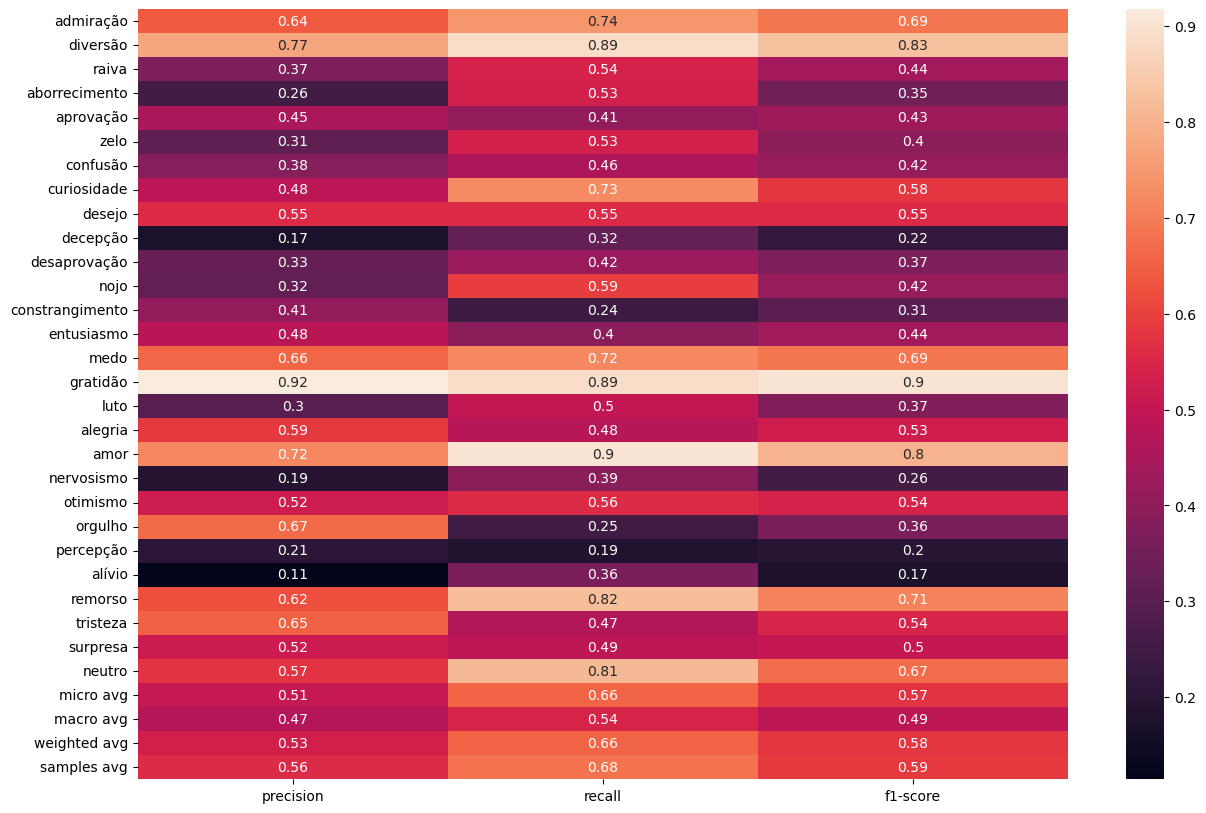

In [51]:
emotion_results = classification_report(np.array(test_labels),np.array(best_preds),target_names=test_labels.columns,output_dict=True,zero_division=0)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(emotion_results).iloc[:-1, :].T, annot=True)

In [52]:


print(log_var_a)
print(log_var_b)


tensor([0.], device='cuda:0', requires_grad=True)
tensor([0.], device='cuda:0', requires_grad=True)
